In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re, os
from pyperclip import copy

libraries = ['pandas', 'polars', 'noir']

In [2]:
results = pd.read_csv('criterion_results/uno.csv')
# group, id, input, measure

In [56]:
def print_line():
    print('-' * 100)

In [6]:
def copy_latex(target: pd.DataFrame, factor: int = 1_000_000):
    target = target.groupby(['group', 'id', 'input'])['measure'].agg(['mean', 'std'])
    new_index = []
    for index in target.index:
        new_index.append((f'\\textbf{{{index[0]}}}', index[1], index[2]))
    target.set_index(pd.MultiIndex.from_tuples(new_index, names=['group', 'id', 'input']), inplace=True)
    target['time'] = target.apply(lambda row: f'{(row["mean"] / factor):.2f} $\\pm$  {(row["std"] / factor):.2f}', axis=1)
    target = target[['time']].pivot_table(index=['group', 'id'], columns='input', values='time', aggfunc='first')
    copy(target.to_latex(escape=False))

In [58]:
def generate_speedup_heatmap(target: pd.DataFrame, prefix: str, logx: bool = True, logy: bool = True):
    target = target[target['id'].isin(['With', 'Closures'])]
    target = target.groupby(['group', 'id', 'input'])['measure'].agg('mean').reset_index()
    target['time'] = target['measure'] / 1_000_000
    target_with = target[target['id'] == 'With'][['group', 'input', 'time']]
    target_closure = target[target['id'] == 'Closures'][['group', 'input', 'time']]
    speedup = target_with.merge(target_closure, on=['group', 'input'], suffixes=('_with', '_closure'), how='inner')
    speedup['speedup'] = speedup['time_closure'] / speedup['time_with']
    speedup_pivot = speedup.pivot_table(index='group', columns='input', values='speedup', aggfunc='first')
    sns.heatmap(speedup_pivot, annot=True, cmap='RdYlGn', cbar_kws={'label': 'Speedup'}, fmt='.2f', center=1.0)
    plt.savefig(f'{prefix}-speedup.png')
    plt.show()
    return speedup

def generate_speedup_line(speedup: pd.DataFrame, prefix: str, logx: bool = True, logy: bool = True):
    sns.lineplot(data=speedup, x='input', y='speedup', hue='group', markers=True, style='group', dashes=False)
    # dashed line at 1
    plt.axhline(1, color='gray', linestyle='--')
    if logx: plt.xscale('log')
    xticks = speedup['input'].unique()
    plt.xticks(ticks=xticks, labels=[str(tick) for tick in xticks])
    plt.savefig(f'{prefix}-speedup-line.png')
    plt.show()

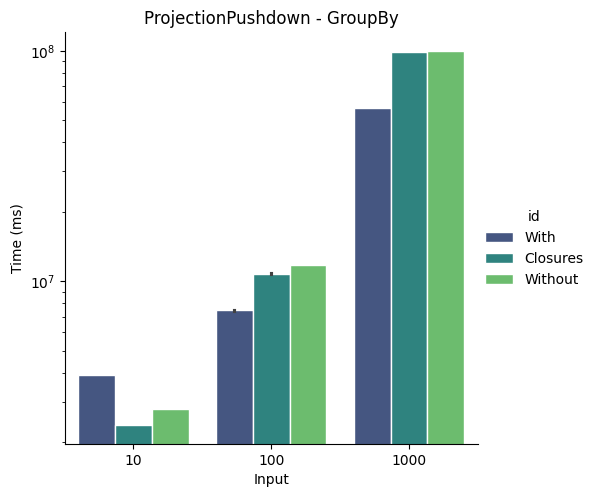

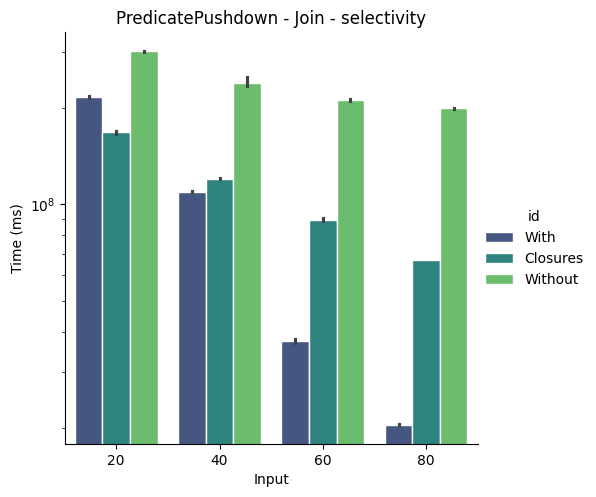

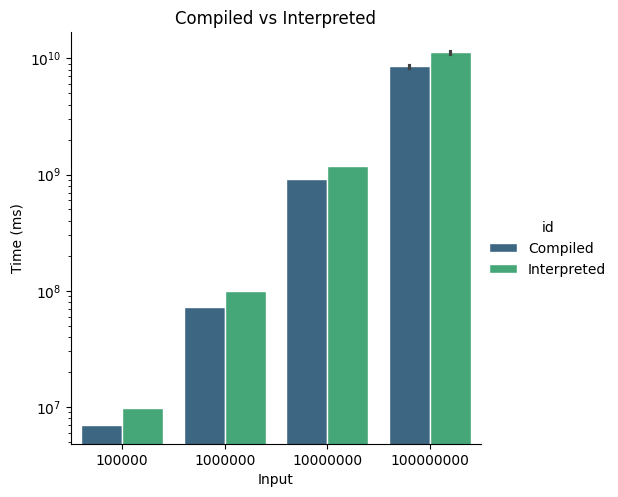

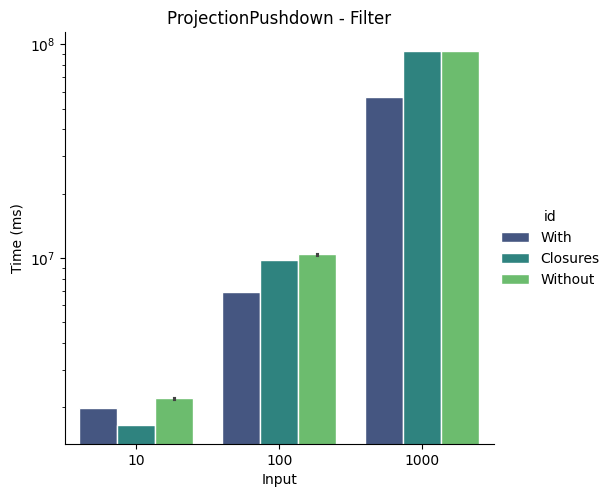

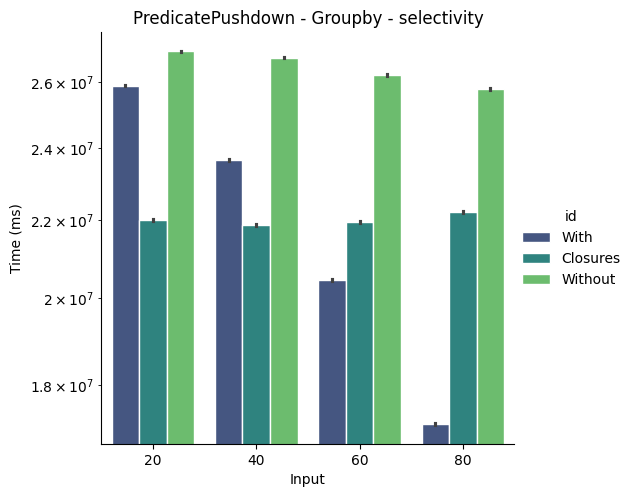

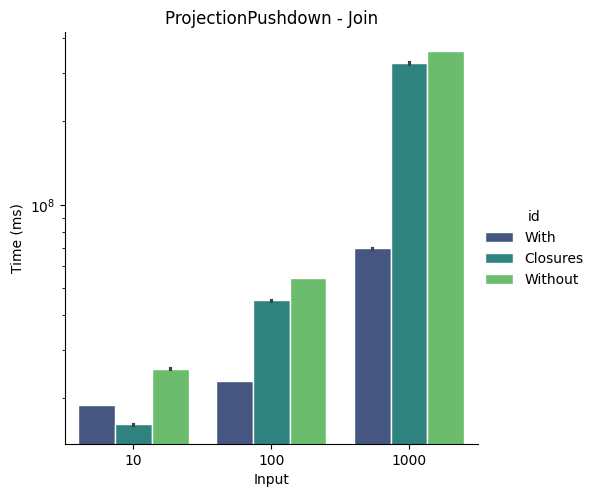

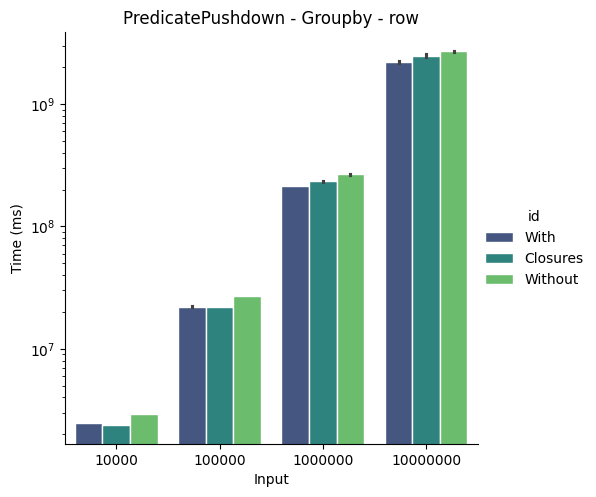

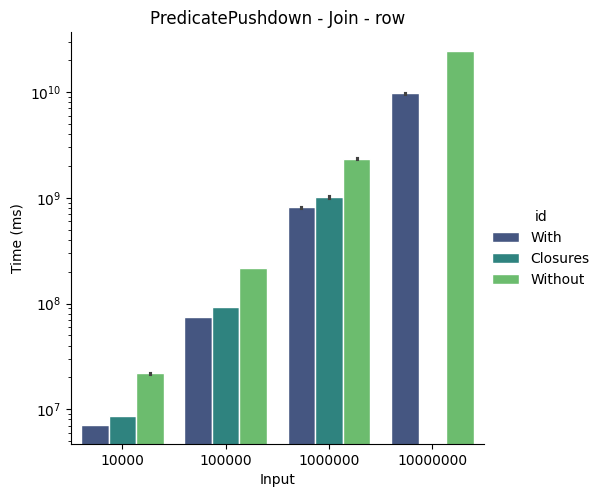

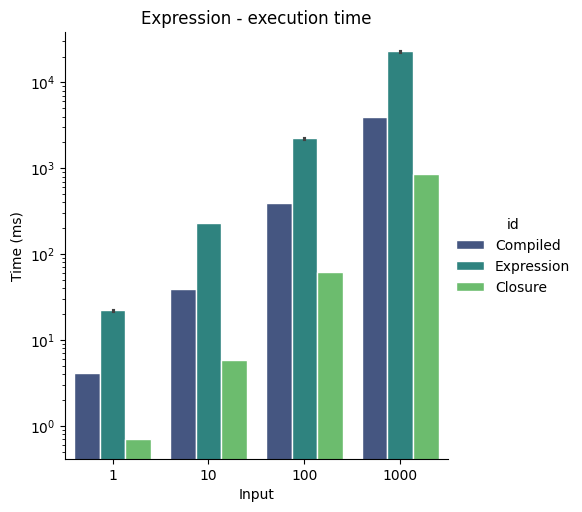

In [59]:
os.makedirs('figures', exist_ok=True)
for group in results['group'].unique():
    measures = results[results['group'] == group]
    g = sns.catplot(data=measures, x='input', y='measure', hue='id', kind='bar', palette='viridis', edgecolor='white')
    plt.title(group)
    plt.ylabel('Time (ms)')
    plt.xlabel('Input')
    plt.yscale('log')
    plt.savefig(f'figures/{group}.png', bbox_inches="tight")

In [60]:
predicate_row = results[results['group'].astype(str).str.match(r'PredicatePushdown - \w+ - row')]
def pr_mapper(row):
    match = re.match(r'PredicatePushdown - (\w+) - row', row['group'])
    row['group'] = match.group(1) if match else '???'
    return row
predicate_row = predicate_row.apply(pr_mapper, axis=1)

predicate_selectivity = results[results['group'].astype(str).str.match(r'PredicatePushdown - \w+ - selectivity')]
def ps_mapper(row):
    match = re.match(r'PredicatePushdown - (\w+) - selectivity', row['group'])
    row['group'] = match.group(1) if match else '???'
    return row
predicate_selectivity = predicate_selectivity.apply(ps_mapper, axis=1)

projection = results[results['group'].astype(str).str.match(r'ProjectionPushdown - \w+')]
def p_mapper(row):
    match = re.match(r'ProjectionPushdown - (\w+)', row['group'])
    row['group'] = match.group(1) if match else '???'
    return row
projection = projection.apply(p_mapper, axis=1)


In [7]:
expressions = results[results['group'].astype(str).str.match(r'Expression - execution time')]
def e_mapper(row):
    row['group'] = 'Expression'
    return row
expressions = expressions.apply(e_mapper, axis=1)

copy_latex(expressions, factor=1)

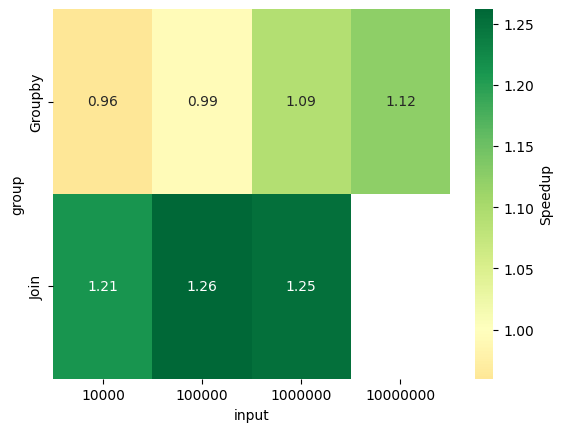

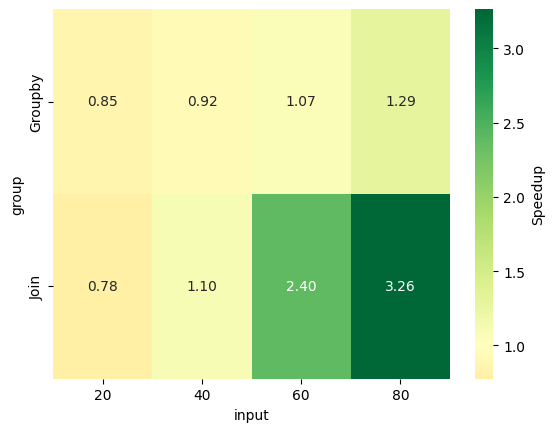

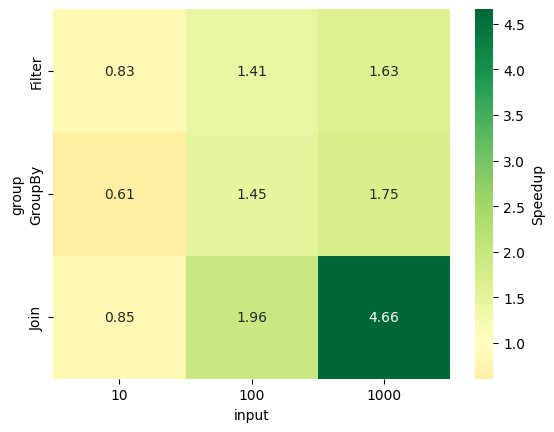

In [61]:
pr_speedup = generate_speedup_heatmap(predicate_row, 'predicate-row')
ps_speedup = generate_speedup_heatmap(predicate_selectivity, 'predicate-selectivity')
p_speedup = generate_speedup_heatmap(projection, 'projection')

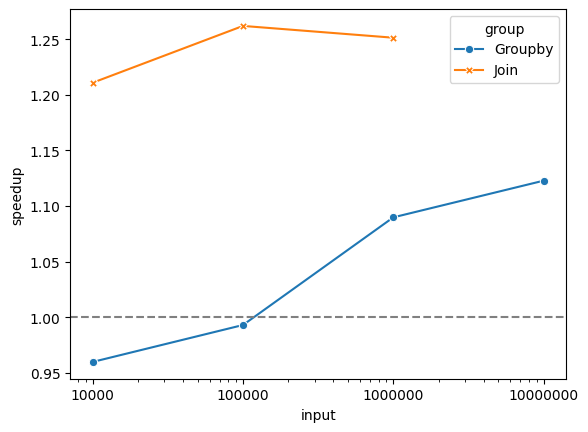

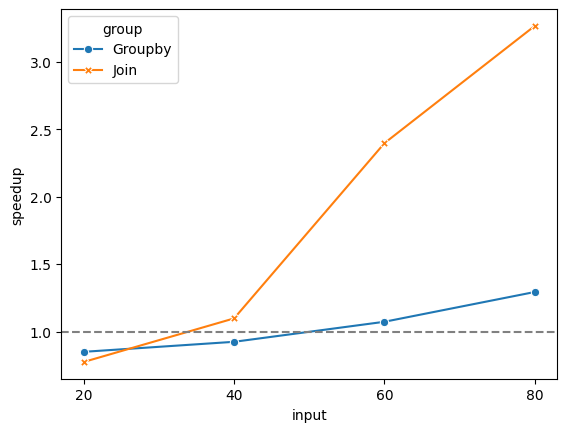

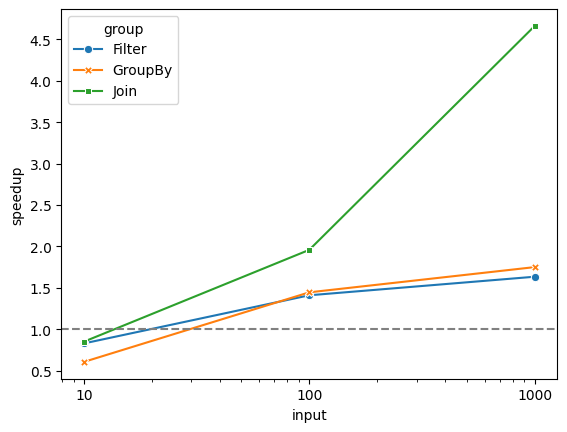

In [62]:
generate_speedup_line(pr_speedup, 'predicate-row')
generate_speedup_line(ps_speedup, 'predicate-selectivity', logx=False)
generate_speedup_line(p_speedup, 'projection')